In [2]:
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 42.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 27.2 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
import math
import importlib
import LibraryEikonal
from LibraryEikonal import  amu,e2,hbarc


In [4]:
# Inputs: this is where you can change the parameters!
#_________________________
# Masses, charges of projectile and target and beam energies
Zt= 6 
Zp= 4
Ap= 10
At= 12
Ebeam= 100  #MeV

#definition optical potential
Vr=250 #MeV 
Wi= 247.9 #MeV
rR=0.687 #fm
aR=0.788 #fm
rI=0.671 #fm
aI=0.709 #fm 
WD=0 #MeV
rD=0.8 #fm 
aD=0.6 #fm 
#Coulomb radius
rc = 1.2 #fm


In [5]:
# Some operations
# Rescaling radii with masses
RR,RI,RD,Rc=LibraryEikonal.RescalingRadii(Ap=Ap,At=At,rR=rR,rI=rI,rD=rD,rc=rc)
# Setup meshes
bmesh,z_mesh,theta_mesh=LibraryEikonal.setup_mesh(bmax=80,Nb=500,zmin=0.1,zmax=50,Nz=100,thmax=40,hth=0.5)
# Setup kinematics
E,mu,k,v,eta=LibraryEikonal.setup_kinematics(Ap=Ap,At=At,Ebeam=Ebeam,Zt=Zt,Zp=Zp)

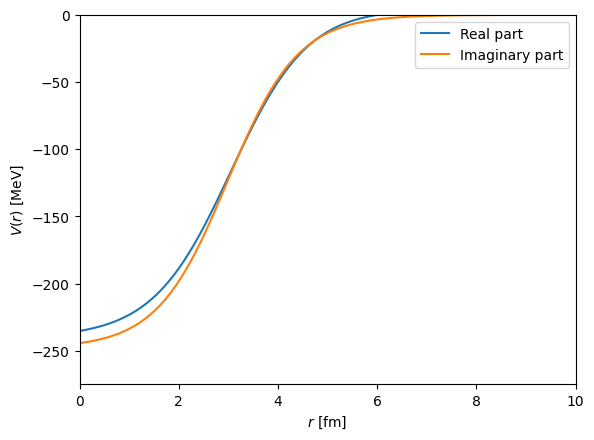

In [6]:
# Compute and plot potential
# Compute it
rmesh=np.linspace(0.001,10,100)
Vpot=LibraryEikonal.optical_potential(r=rmesh,Vr=Vr, RR=RR, aR=aR,\
                                      Wi=Wi, RI=RI, aI=aI,WD=WD,RD=RD,aD=aD)\
     +LibraryEikonal.VC(Zt=Zt,Zp=Zp,Rc=Rc,r=rmesh)

#Plot it
plt.figure()
plt.ylim(-1.1*max(Vr,Wi),0)
plt.xlim(0,max(rmesh))
plt.plot(rmesh,Vpot.real, label='Real part')
plt.plot(rmesh,Vpot.imag, label='Imaginary part')
plt.legend()
plt.xlabel(r'$r$ [fm]')
plt.ylabel('$V(r)$ [MeV]')
plt.show()

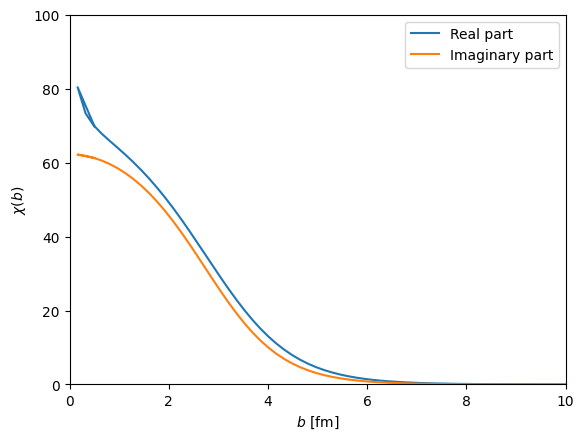

In [7]:
# Computing eikonal phase
# eikonal phase
chi=LibraryEikonal.EikonalPhase(bmesh,z_mesh,Vr, RR, aR, Wi, RI, aI, WD, RD, aD,Zt, Zp, Rc,v)

# Plot the eikonal phase
plt.figure()
plt.xlim(0,10)
plt.ylim(0,100)
plt.plot(bmesh,chi.real, label='Real part')
plt.plot(bmesh,chi.imag, label='Imaginary part')
plt.legend()
plt.xlabel(r'$b$ [fm]')
plt.ylabel('$\chi(b)$')
plt.show()

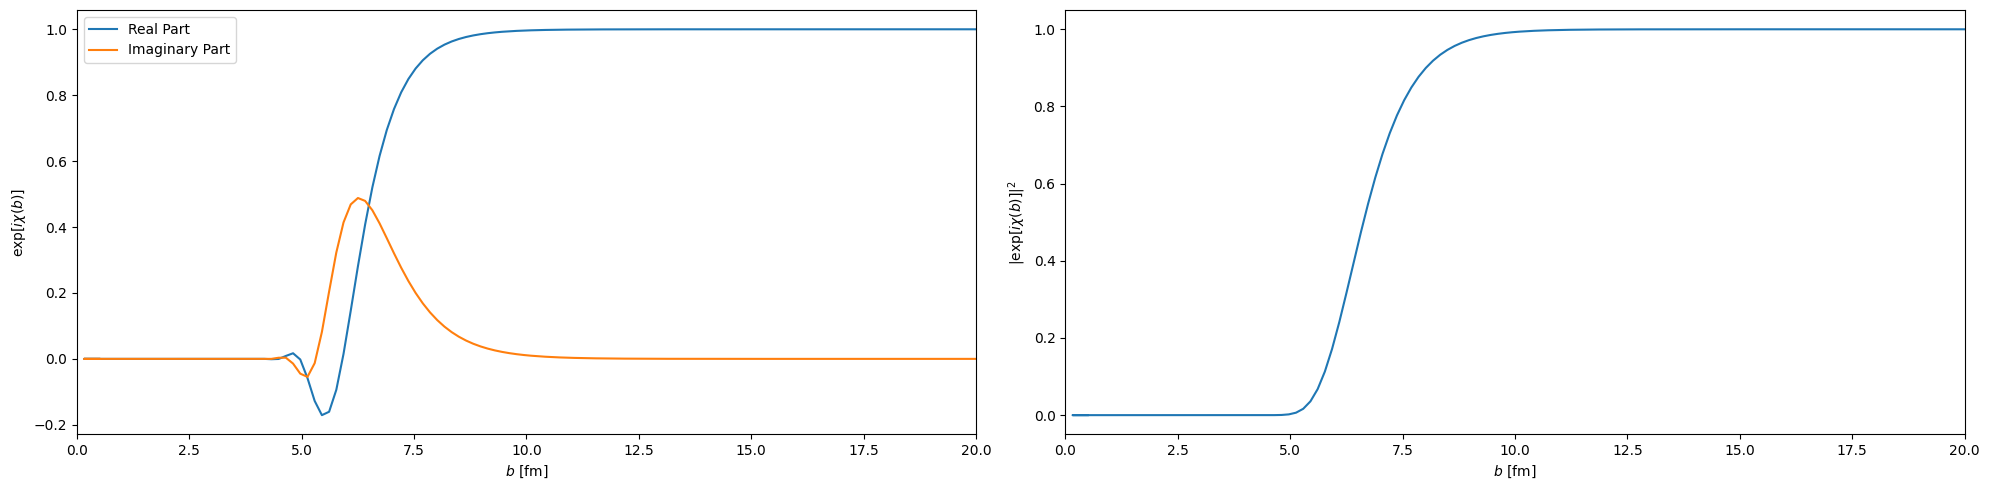

In [8]:
# plot eikonal S-matrix
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(bmesh,np.exp(1j*chi).real,label=r'Real Part')
axs[0].plot(bmesh,np.exp(1j*chi).imag,label=r'Imaginary Part')
axs[0].legend()
axs[0].set_xlim(0,20)
axs[0].set_xlabel(r'$b$ [fm]')
axs[0].set_ylabel(r'$\exp [i \chi(b)]$')           
axs[1].plot(bmesh,abs(np.exp(1j*chi))**2)
axs[1].set_xlabel(r'$b$ [fm]')
axs[1].set_ylabel(r'$|\exp [i \chi(b)]|^2$')  
axs[1].set_xlim(0,20)
plt.tight_layout()
plt.show()

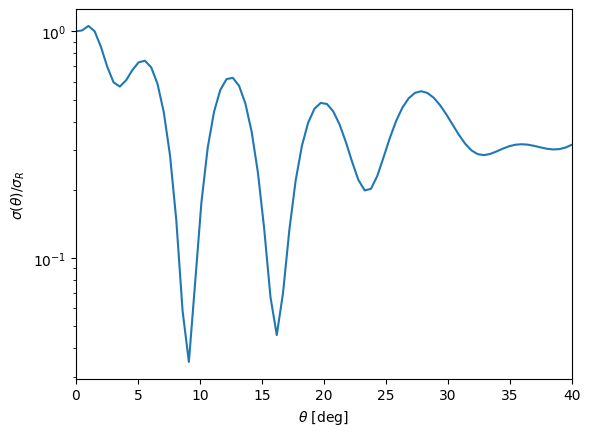

In [9]:
# Compute elastic cross section 
el_cross_section=LibraryEikonal.ElScatCS_eik(theta_mesh,bmesh,chi,k,eta)

# Plot elastic cross sections
plt.figure()
plt.yscale('log')
plt.xlim(0,max(theta_mesh*180/(np.pi)))
plt.xlabel(r'$\theta$ [deg]')
if Zp*Zt!=0:
    rutherford_crosssection = LibraryEikonal.rutherford_cs(theta_mesh,eta,k)    
    plt.plot(theta_mesh*(180/(np.pi)), el_cross_section / rutherford_crosssection)
    plt.ylabel(r'$\sigma(\theta)/\sigma_R$')    
else:
    plt.plot(theta_mesh*(180/(np.pi)), el_cross_section)
    plt.ylabel(r'$\sigma(\theta)$')
plt.show()



In [10]:

# Compute total elastic cross section (if no Coulomb), absorption cross section, total cross scetion
#total elastic
if Zp*Zt==0:
    sig_el_tot= LibraryEikonal.sig_el_eik(chi,bmesh)
    print('Elastic cross section',"%3.1f"%sig_el_tot,'b')    
    
#absorption cross section
sig_reac=LibraryEikonal.sig_abs_eik(chi,bmesh)
print('Reaction cross section',"%3.1f"%sig_reac,'b')

#total cross section
if Zp*Zt==0:
    sig_tot=LibraryEikonal.sig_tot_eik(chi,bmesh)
    print('Total cross section',"%3.1f"%sig_tot,'b')    
    if abs(sig_tot-sig_el_tot-sig_reac)/sig_tot>1e-2:
        print(r'ERROR: $\sigma_{tot}\neq \sigma_{el}+\sigma_{abs}$')

Reaction cross section 146.4 b
